## Data / Package Import 

In [1]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, Layer, Add, GlobalAveragePooling1D, Conv1D, ReLU
from sklearn.model_selection import KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
import scipy.stats as stats
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from accelerate import DataLoaderConfiguration
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l1
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## AMGM and Cosine Feature Selection

In [2]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [3]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

## Autoencoder Feature Selection with Lasso Regression

In [2]:
def create_feature_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoder part
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoder part
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [3]:
def apply_l1_feature_selection(X, y, alpha=0.01, target_features=100):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    model = SelectFromModel(lasso, prefit=True, max_features=target_features)
    X_reduced = model.transform(X)
    selected_indices = model.get_support(indices=True)
    return X_reduced, selected_indices

## Initial Deep Autoencoder

In [4]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [5]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv' #Change for different files

In [7]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [8]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [9]:
amgm_values = calculate_amgm(X)

In [10]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [11]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [234413 206406 232276 250927 321802 270758 200059 197015 126599 374361]
Top AMGM values: [1.01338819 1.01339466 1.01339466 1.01339577 1.013396   1.01339625
 1.01339625 1.01340604 1.01340653 1.01340799]


In [12]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [13]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [14]:
X_selected = X[selected_indices, :].T 

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,826 (50.10 KB)

 Trainable params: 12,826 (50.10 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9755 - loss: 0.0889 - val_accuracy: 1.0000 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9172 - loss: 0.1651 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9897 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9509 - loss: 0.0709 - val_accuracy: 1.0000 - val_loss: 0.0085 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9716 - loss: 0.0589 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9794 - loss: 0.0718 - val_accuracy: 1.0000 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0299 - val_accuracy: 1.0000 

In [25]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.9130434782608695
F1 Score: 0.9285714285714286


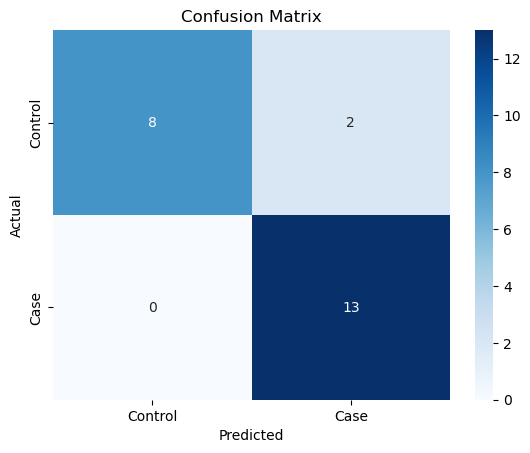

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.9130434782608695
F1 Score: 0.9285714285714286
Specificity: 0.8
Sensitivity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization)

In [28]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [29]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [30]:
amgm_values = calculate_amgm(X)

In [31]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [32]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [234413 206406 232276 250927 321802 270758 200059 197015 126599 374361]
Top AMGM values: [1.01338819 1.01339466 1.01339466 1.01339577 1.013396   1.01339625
 1.01339625 1.01340604 1.01340653 1.01340799]


In [33]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [34]:
X_selected = X[selected_indices, :].T

In [35]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [36]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values  

In [37]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [39]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [40]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000255BEC19A80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.9557522123893806, F1 Score: 0.9618320610687023, Sensitivity: 0.9545454545454546, Specificity: 0.9574468085106383
Accuracy: 0.9823008849557522, 

In [41]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 0.9823008849557522
Best F1 Score: 0.9848484848484849
Best Specificity: 0.9787234042553191
Best Sensitivity: 0.9848484848484849


In [42]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_505 (Dense)                    │ (None, 224)                 │          22,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_202 (Dropout)                │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_506 (Dense)                    │ (None, 16)                  │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_507 (Dense)                    │ (None, 224)                 │           3,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_508 (Dense)                    │ (None, 100)                 │          22,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_509 (Dense)                    │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,633 (205.60 KB)

 Trainable params: 52,633 (205.60 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 224
Neurons in second layer: 16
Dropout rate: 0.41702030432762127
Learning rate: 0.00022142276787805485
Number of epochs: 100
Batch size: 96


## Bidirectional LSTM with Bayesian Optimization

In [58]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [59]:
Input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\2250372466.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [60]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [61]:
amgm_values = calculate_amgm(X)

In [62]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [63]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [234413 206406 232276 250927 321802 270758 200059 197015 126599 374361]
Top AMGM values: [1.01338819 1.01339466 1.01339466 1.01339577 1.013396   1.01339625
 1.01339625 1.01340604 1.01340653 1.01340799]


In [64]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [65]:
X_selected = X[selected_indices, :].T

In [66]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [67]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
space = {
    'units': scope.int(hp.quniform('units', 32, 128, 32)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [69]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [70]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 0.9777777777777779, F1 Score: 0.9833333333333334, Sensitivity: 0.9833333333333334, Specificity: 0.9666666666666667
Iteration Results - Accuracy: 0.8000000000000002, F1 Score: 0.8248677248677249, Sensitivity: 0.8370098039215685, Specificity: 0.706959706959707
Iteration Results - Accuracy: 0.9444444444444445, F1 Score: 0.959349593495935, Sensitivity: 0.9666666666666667, Specificity: 0.9
Iteration Results - Accuracy: 0.9444444444444445, F1 Score: 0.959349593495935, Sensitivity: 0.9666666666666667, Specificity: 0.9
Iteration Results - Accuracy: 0.9222222222222222, F1 Score: 0.9422799422799423, Sensitivity: 0.9666666666666667, Specificity: 0.8428571428571429
Iteration Results - Accuracy: 0.9111111111111111, F1 Score: 0.9138813610358326, Sensitivity: 0.8791666666666668, Specificity: 0.9333333333333332
Iteration Results - Accuracy: 0.9444444444444445, F1 Score: 0.9559139784946237, Sensitivity: 0.9458333333333333, Specificity: 0.9333333333333332
Iteration Results 

In [71]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 64, 'dropout_rate': 0.4611060983665523, 'learning_rate': 0.0019509237966000132, 'epochs': 30, 'batch_size': 16, 'bidirectional': 0}


In [72]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step

Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Gru with Bayesian Optimization

In [96]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [97]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [98]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [99]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [100]:
amgm_values = calculate_amgm(X)

In [101]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [102]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [103]:
X_selected = X[selected_indices, :].T

In [104]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [105]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [106]:
space = {
    'units': scope.int(hp.quniform('units', 32, 64, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.4),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [107]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [108]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.9333333333333332, F1 Score: 0.9370587596394048, Sensitivity: 0.897348484848485, Specificity: 0.9583333333333334
Iteration Results - Accuracy: 0.9666666666666667, F1 Score: 0.9777777777777779, Sensitivity: 0.9848484848484849, Specificity: 0.9166666666666666
Iteration Results - Accuracy: 0.8666666666666667, F1 Score: 0.8889027812508683, Sensitivity: 0.9195707070707071, Specificity: 0.8222222222222223
Iteration Results - Accuracy: 0.9777777777777779, F1 Score: 0.9807538091419407, Sensitivity: 0.9626262626262626, Specificity: 1.0
Iteration Results - Accuracy: 0.5777777777777777, F1 Score: 0.710516536603493, Sensitivity: 0.8939393939393939, Specificity: 0.25
Iteration Results - Accuracy: 0.7666666666666666, F1 Score: 0.7844651374063139, Sensitivity: 0.7468434343434343, Specificity: 0.8202380952380953
Iteration Results - Accuracy: 0.9777777777777779, F1 Score: 0.9814953738434609, Sensitivity: 0.9848484848484849, Specificity: 0.9777777777777779
Iteration Result

In [109]:
best_params = space_eval(space, best)
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 64, 'dropout_rate': 0.24366944217613146, 'epochs': 30, 'learning_rate': 0.005064932515917304, 'units': 32}


In [110]:
best_model = create_gru_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [111]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [112]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [113]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step

Test Performance:
Accuracy: 0.9565217391304348
F1 Score: 0.9629629629629629
Sensitivity: 1.0
Specificity: 0.9


## CNN with Bayesian Optimization

In [115]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [116]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [117]:
amgm_values = calculate_amgm(X)

In [118]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [119]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [120]:
X_selected = X[selected_indices, :].T

In [121]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [122]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [123]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [124]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [125]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [126]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [127]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                                

Iteration Results - Accuracy: 0.888888888888889, F1 Score: 0.8852258852258852, Sensitivity: 0.7974747474747476, Specificity: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                

1/1 ━━

In [128]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.2032790134283512, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.0017143166976029654}


In [129]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [139]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [140]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [141]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.6956521739130435
F1 Score: 0.631578947368421
Sensitivity: 0.46153846153846156
Specificity: 1.0


## ResNet

In [145]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [146]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [147]:
amgm_values = calculate_amgm(X)

In [148]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [149]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [150]:
X_selected = X[selected_indices, :].T

In [151]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [152]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [154]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [155]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [156]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [157]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [158]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 32, 'dropout_rate': 0.31037270128792305, 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'learning_rate': 0.00037352916999596023, 'num_blocks': 6}
Iteration - Loss: 0.3751348555088043, Filters: 64, Blocks: 6, Kernel Size: 3, Dropout: 0.31037270128792305, LR: 0.00037352916999596023, Batch Size: 32, Epochs: 30
Trying params: {'batch_size': 48, 'dropout_rate': 0.35730373258054515, 'epochs': 50, 'filters': 32, 'kernel_size': 4, 'learning_rate': 0.00025613864490188075, 'num_blocks': 6}
Iteration - Loss: 0.20881536602973938, Filters: 32, Blocks: 6, Kernel Size: 4, Dropout: 0.35730373258054515, LR: 0.00025613864490188075, Batch Size: 48, Epochs: 50
Trying params: {'batch_size': 48, 'dropout_rate': 0.3799821189098427, 'epochs': 50, 'filters': 128, 'kernel_size': 4, 'learning_rate': 0.008773189297667355, 'num_blocks': 8}
Iteration - Loss: 173.6019744873047, Filters: 128, Blocks: 8, Kernel Size: 4, Dropout: 0.3799821189098427, LR: 0.008773189297667355, Batch Size: 48

In [159]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 32, 'dropout_rate': 0.20964473958217855, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.005580223068233856, 'num_blocks': 8}


In [160]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [161]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step - accuracy: 0.7115 - loss: 0.5586 - val_accuracy: 0.7778 - val_loss: 3.3159
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step - accuracy: 0.9837 - loss: 0.0503 - val_accuracy: 0.7778 - val_loss: 6.9253
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step - accuracy: 0.9698 - loss: 0.1053 - val_accuracy: 0.7778 - val_loss: 44.6874
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 0.9759 - loss: 0.1069 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 392ms/step - accuracy: 0.9659 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 1.4000e-13
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step - accuracy: 0.9620 - loss: 0.0836 - val_accuracy: 0.8889 - val_loss: 8.9551
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - accuracy: 0.9620 - loss: 0.1030 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [162]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [163]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.9130434782608695
F1 Score: 0.9285714285714286
Sensitivity: 1.0
Specificity: 0.8


## FNN with Bayesian Optimization

In [164]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7784\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [165]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [166]:
amgm_values = calculate_amgm(X)

In [167]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [168]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [169]:
X_selected = X[selected_indices, :].T

In [170]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [171]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [173]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [174]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [175]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [176]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 2.2435713287194403e-09, Params: {'batch_size': 48, 'dropout_rate': 0.31854078550198983, 'epochs': 140, 'learning_rate': 0.008033133981585448, 'num_layers': 5, 'units': 224}
Iteration - Loss: 0.4306385815143585, Params: {'batch_size': 80, 'dropout_rate': 0.3351302316018883, 'epochs': 150, 'learning_rate': 2.259784027477487e-05, 'num_layers': 2, 'units': 160}
Iteration - Loss: 0.18210694193840027, Params: {'batch_size': 80, 'dropout_rate': 0.4546830304266659, 'epochs': 130, 'learning_rate': 0.00025494829795176, 'num_layers': 3, 'units': 96}
Iteration - Loss: 5.316756692026747e-13, Params: {'batch_size': 64, 'dropout_rate': 0.4495378097682131, 'epochs': 140, 'learning_rate': 0.007940987500121417, 'num_layers': 5, 'units': 160}
Iteration - Loss: 0.6140477657318115, Params: {'batch_size': 128, 'dropout_rate': 0.33699937996033413, 'epochs': 130, 'learning_rate': 1.6006728305236678e-05, 'num_layers': 5, 'units': 160}
Iteration - Loss: 0.5294206738471985, Params: {'batch_size

In [177]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.3992527399121967, 'epochs': 130, 'learning_rate': 0.0058037326290321725, 'num_layers': 4, 'units': 256}


In [178]:
best_model = create_fnn_model(input_dim=X_train.shape[1],
                              num_layers=best_params['num_layers'],
                              units=best_params['units'],
                              dropout_rate=best_params['dropout_rate'],
                              learning_rate=best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7040 - loss: 0.6260 - val_accuracy: 0.4444 - val_loss: 0.6976
Epoch 2/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7407 - loss: 0.4696 - val_accuracy: 1.0000 - val_loss: 0.0127
Epoch 3/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9684 - loss: 0.1600 - val_accuracy: 1.0000 - val_loss: 4.3490e-04
Epoch 4/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9614 - loss: 0.1005 - val_accuracy: 1.0000 - val_loss: 2.9878e-05
Epoch 5/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 9.9178e-04 - val_accuracy: 1.0000 - val_loss: 2.5445e-06
Epoch 6/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9848 - loss: 0.0328 - val_accuracy: 1.0000 - val_loss: 2.7564e-09
Epoch 7/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1240e-06 - val_accuracy: 1.0000 - val_loss: 2.0122e-10
Epoch 8/130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 2.1645e-06 -

In [179]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Test Performance:
Accuracy: 0.9130434782608695
F1 Score: 0.9285714285714286
Sensitivity: 1.0
Specificity: 0.8


## BERT Transformer

In [2]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_17656\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [23]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
labels = case_control_info.map({'Control': 0, 'Case': 1}).values
features_df = features_df.apply(pd.to_numeric, errors='coerce').fillna(0)

In [24]:
amgm_values = calculate_amgm(features_df.values)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [25]:
selected_indices = filter_redundant_features(features_df.values, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1000]

In [26]:
X_selected = features_df.iloc[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [27]:
sequences = [' '.join(map(str, row)) for row in X_selected]

In [28]:
class SNPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [29]:
def objective(trial):
    # Suggest hyperparameters
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 3)  # Reduced number of epochs for faster trials
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # Higher batch sizes might not fit in memory
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    max_length = trial.suggest_int('max_length', 128, 256)  # Reduced sequence length

    # Load DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Create PyTorch Datasets
    train_dataset = SNPDataset(train_encodings, train_labels)
    val_dataset = SNPDataset(val_encodings, val_labels)

    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        save_strategy="epoch",
        save_total_limit=1  # Keep only the last checkpoint
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate(eval_dataset=val_dataset)

    # Return the evaluation metric to be minimized
    return eval_result['eval_loss']

In [30]:
study = optuna.create_study(direction='minimize')

[I 2024-06-12 12:11:29,630] A new study created in memory with name: no-name-0c4959d6-1cf7-423f-8970-b8baf311517b


In [31]:
study.optimize(objective, n_trials=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.685932
2,No log,0.683229


[I 2024-06-12 12:12:45,686] Trial 0 finished with value: 0.683229386806488 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 4.1604152755614585e-05, 'max_length': 203}. Best is trial 0 with value: 0.683229386806488.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.693585
2,No log,0.689987
3,No log,0.685414


[I 2024-06-12 12:14:53,207] Trial 1 finished with value: 0.6854141354560852 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 3.6294375127138535e-05, 'max_length': 213}. Best is trial 0 with value: 0.683229386806488.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.684753
2,0.685600,0.678223
3,0.685600,0.669782


[I 2024-06-12 12:16:14,449] Trial 2 finished with value: 0.6697818040847778 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 3.644869073892524e-05, 'max_length': 130}. Best is trial 2 with value: 0.6697818040847778.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.701090
2,No log,0.697084


[I 2024-06-12 12:17:21,736] Trial 3 finished with value: 0.697083592414856 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 2.5556506203339093e-05, 'max_length': 171}. Best is trial 2 with value: 0.6697818040847778.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.695113
2,No log,0.692473
3,No log,0.688492


[I 2024-06-12 12:18:36,183] Trial 4 finished with value: 0.6884921193122864 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 2.459227543029821e-05, 'max_length': 144}. Best is trial 2 with value: 0.6697818040847778.


In [32]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 3.644869073892524e-05, 'max_length': 130}


In [33]:
best_params = study.best_params

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
train_dataset = SNPDataset(train_encodings, train_labels)
val_dataset = SNPDataset(val_encodings, val_labels)

In [36]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.823956
2,0.847000,0.770024
3,0.847000,0.682706


TrainOutput(global_step=18, training_loss=0.8175236119164361, metrics={'train_runtime': 556.6451, 'train_samples_per_second': 0.485, 'train_steps_per_second': 0.032, 'total_flos': 71039984947200.0, 'train_loss': 0.8175236119164361, 'epoch': 3.0})

In [39]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds)
conf_matrix = confusion_matrix(val_labels, preds)

# Compute specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.6086956521739131
F1 Score: 0.6896551724137931
Sensitivity: 0.7692307692307693
Specificity: 0.4


## Sparse Autoencoder

In [5]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_18236\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [6]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values
X = X.T

In [7]:
amgm_values = calculate_amgm(X)

In [8]:
num_features = 25000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [9]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:2500] 

In [10]:
X_selected = X[:, selected_indices]

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X_selected)
X_train, X_val, y_train, y_val= train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [12]:
def create_sparse_autoencoder(input_dim, num_units, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer))(input_layer)
    encoder = Dropout(dropout_rate)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [13]:
def objective(trial):
    # Hyperparameters to tune
    num_units = trial.suggest_int('num_units', 64, 256)  # Reduced upper bound
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Lower upper bound
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)  # Reduced upper bound
    activity_regularizer = trial.suggest_float('activity_regularizer', 1e-7, 1e-4, log=True)  # Reduced range
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Reduced upper bound

    # Create the model
    model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=num_units, dropout_rate=dropout_rate, activity_regularizer=activity_regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    # Set early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, X_train, epochs=50, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')], verbose=0)

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-13 09:27:32,544] A new study created in memory with name: no-name-e7479900-127f-46df-bb1a-00758c14fa92
[I 2024-06-13 09:27:36,742] Trial 0 finished with value: 0.018329212442040443 and parameters: {'num_units': 112, 'learning_rate': 2.324076655633723e-05, 'dropout_rate': 0.1941926107252109, 'activity_regularizer': 2.5458229765663954e-06, 'batch_size': 61}. Best is trial 0 with value: 0.018329212442040443.
[I 2024-06-13 09:27:40,827] Trial 1 finished with value: 0.01749476045370102 and parameters: {'num_units': 112, 'learning_rate': 3.4893657692315844e-05, 'dropout_rate': 0.29000063770019213, 'activity_regularizer': 4.7881467717073226e-05, 'batch_size': 32}. Best is trial 1 with value: 0.01749476045370102.
[I 2024-06-13 09:27:44,575] Trial 2 finished with value: 0.022458521649241447 and parameters: {'num_units': 178, 'learning_rate': 6.341780337122132e-05, 'dropout_rate': 0.16703196151862273, 'activity_regularizer': 8.594642648683724e-05, 'batch_size': 36}. Best is trial 1 wi

[I 2024-06-13 09:28:07,864] Trial 10 finished with value: 0.005469358526170254 and parameters: {'num_units': 226, 'learning_rate': 0.00021787719556293979, 'dropout_rate': 0.002877132869698512, 'activity_regularizer': 1.575959129952679e-07, 'batch_size': 17}. Best is trial 10 with value: 0.005469358526170254.
[I 2024-06-13 09:28:12,252] Trial 11 finished with value: 0.002589585492387414 and parameters: {'num_units': 226, 'learning_rate': 0.0009717647835152961, 'dropout_rate': 0.017675088986647075, 'activity_regularizer': 1.0906208316333914e-07, 'batch_size': 18}. Best is trial 11 with value: 0.002589585492387414.
[I 2024-06-13 09:28:16,568] Trial 12 finished with value: 0.002261972986161709 and parameters: {'num_units': 235, 'learning_rate': 0.0009966320967166595, 'dropout_rate': 0.003933775770542816, 'activity_regularizer': 1.0165428366352855e-07, 'batch_size': 16}. Best is trial 12 with value: 0.002261972986161709.
[I 2024-06-13 09:28:20,885] Trial 13 finished with value: 0.0026993195

[I 2024-06-13 09:28:34,402] Trial 20 pruned. Trial was pruned at epoch 1.
[I 2024-06-13 09:28:35,267] Trial 21 pruned. Trial was pruned at epoch 0.
[I 2024-06-13 09:28:39,740] Trial 22 finished with value: 0.004069867543876171 and parameters: {'num_units': 216, 'learning_rate': 0.0006352553411516211, 'dropout_rate': 0.02143856376482454, 'activity_regularizer': 2.133555270213689e-07, 'batch_size': 19}. Best is trial 12 with value: 0.002261972986161709.
[I 2024-06-13 09:28:40,594] Trial 23 pruned. Trial was pruned at epoch 0.
[I 2024-06-13 09:28:45,082] Trial 24 finished with value: 0.003570794127881527 and parameters: {'num_units': 195, 'learning_rate': 0.0009030068173266975, 'dropout_rate': 0.06317240140863548, 'activity_regularizer': 1.9287336687651815e-07, 'batch_size': 20}. Best is trial 12 with value: 0.002261972986161709.
[I 2024-06-13 09:28:45,800] Trial 25 pruned. Trial was pruned at epoch 0.
[I 2024-06-13 09:28:47,736] Trial 26 pruned. Trial was pruned at epoch 15.
[I 2024-06-1

[I 2024-06-13 09:28:51,611] Trial 30 pruned. Trial was pruned at epoch 0.


[I 2024-06-13 09:28:55,977] Trial 31 finished with value: 0.002002999885007739 and parameters: {'num_units': 251, 'learning_rate': 0.0008454861971241022, 'dropout_rate': 0.04721719574807189, 'activity_regularizer': 4.287282108577875e-07, 'batch_size': 16}. Best is trial 31 with value: 0.002002999885007739.
[I 2024-06-13 09:29:00,209] Trial 32 finished with value: 0.0027384196873754263 and parameters: {'num_units': 239, 'learning_rate': 0.0007408368987855757, 'dropout_rate': 0.037860079043161625, 'activity_regularizer': 2.732998170168504e-07, 'batch_size': 16}. Best is trial 31 with value: 0.002002999885007739.
[I 2024-06-13 09:29:05,078] Trial 33 finished with value: 0.002385879633948207 and parameters: {'num_units': 233, 'learning_rate': 0.0007488479375379893, 'dropout_rate': 0.008611612854635624, 'activity_regularizer': 1.0297392736088668e-07, 'batch_size': 19}. Best is trial 31 with value: 0.002002999885007739.
[I 2024-06-13 09:29:09,483] Trial 34 finished with value: 0.003759708721

In [15]:
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'num_units': 251, 'learning_rate': 0.0008454861971241022, 'dropout_rate': 0.04721719574807189, 'activity_regularizer': 4.287282108577875e-07, 'batch_size': 16}


In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [17]:
best_model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=best_params['num_units'], dropout_rate=best_params['dropout_rate'], activity_regularizer=best_params['activity_regularizer'])
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss=MeanSquaredError())
best_model.fit(X_train, X_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0144 - val_loss: 0.0130
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0075
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 13/50


In [18]:
val_loss = best_model.evaluate(X_val, X_val)
print("Validation Loss: ", val_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026
Validation Loss:  0.002561886329203844


In [19]:
reconstructions = best_model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [20]:
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)

In [21]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

In [22]:
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.43478260869565216
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Stacked Autoencoder & LSTM Model

In [24]:
Input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_18236\2250372466.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [25]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [26]:
X = X.astype('float32')
y = y.astype('float32')

In [27]:
amgm_values = calculate_amgm(X)

In [28]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [29]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [234413 232276 206406 321802 250927 200059 270758 197015 126599 374361]
Top AMGM values: [1.0133886 1.0133953 1.0133953 1.0133955 1.0133955 1.0133958 1.0133958
 1.013406  1.0134064 1.0134076]


In [30]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [31]:
X_selected = X[selected_indices, :].T
X_selected = X_selected.astype('float32')

In [32]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected).astype('float32')

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [34]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [35]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [36]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [37]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [38]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [39]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step                                              

  0%|                                                                           | 0/20 [00:49<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B39F738680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) pa

In [40]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 1.0195871483792565e-05, 'ae_batch_size': 57.0, 'ae_dropout_rate': 0.22040522447053654, 'ae_learning_rate': 0.0005596463584347175, 'autoencoder_units': 254.0, 'encoding_dim': 75.0, 'lstm_batch_size': 26.0, 'lstm_dropout_rate': 0.3930555875166011, 'lstm_learning_rate': 0.0002577472225551129, 'lstm_units': 448.0}


In [41]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [42]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [43]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [44]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 1.2458 - val_loss: 1.2634
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2419 - val_loss: 1.2513
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2259 - val_loss: 1.2384
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.2031 - val_loss: 1.2237
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1867 - val_loss: 1.2064
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1761 - val_loss: 1.1863
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1388 - val_loss: 1.1633
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1147 - val_loss: 1.1380
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0917 - val_loss: 1.1112
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.0678 - val_loss: 1.0847
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0335 - val_loss: 1.0605
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0128 - val_loss: 1.0400


In [45]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
Accuracy: 0.9565217391304348
F1 Score: 0.9629629629629629
Sensitivity: 1.0
Specificity: 0.9


## Stacked Autoencoder & FNN Model

In [4]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_24364\1386095298.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [5]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

In [6]:
amgm_values = calculate_amgm(X)

In [7]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [8]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [234413 232276 206406 321802 250927 200059 270758 197015 126599 374361]
Top AMGM values: [1.0133886 1.0133953 1.0133953 1.0133955 1.0133955 1.0133958 1.0133958
 1.013406  1.0134064 1.0134076]


In [9]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [10]:
X_selected = X[selected_indices, :].T

In [11]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [13]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
def ensure_float32(data):
    return data.astype(np.float32)

In [15]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [16]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [17]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [19]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [20]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step                                                
  0%|                                                                           | 0/20 [00:05<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000026779B3CEA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outs

In [21]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [22]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [23]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Final Model - Accuracy: 0.9666666666666666
Final Model - F1 Score: 0.9697777777777776
Final Model - Sensitivity: 0.9623931623931623
Final Model - Specificity: 0.9777777777777779


## Deep Autoencoder with L1 Feature Selection

In [59]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [60]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedBreastCancerData.csv' #Change for different files

In [7]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_17932\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0

In [8]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [9]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
X_scaled = X_scaled.T

In [12]:
input_dim = X_scaled.shape[1]
encoding_dim = 1000

In [13]:
autoencoder, encoder = create_feature_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 1.2502 - val_loss: 1.2402
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 1.2422 - val_loss: 1.2454
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 1.1462 - val_loss: 1.2418
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9945 - val_loss: 1.2343
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9888 - val_loss: 1.2253
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9859 - val_loss: 1.2174
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9830 - val_loss: 1.2110
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9795 - val_loss: 1.2052
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9759 - val_loss: 1.2000
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 0.9730 - val_loss: 1.1960
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9701 - val_loss: 1.1931
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.9675 - val_loss: 1.1907
E

In [14]:
X_encoded = encoder.predict(X_scaled)
print(f"Shape of encoded features: {X_encoded.shape}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step
Shape of encoded features: (225, 1000)


In [15]:
target_features = 200  # Target number of features
X_final, selected_indices_l1 = apply_l1_feature_selection(X_encoded, y, alpha=0.005, target_features=target_features)
print(f"Shape after L1-based Feature Selection: {X_final.shape}")

Shape after L1-based Feature Selection: (225, 200)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e-02, tolerance: 5.504e-03
  model = cd_fast.enet_coordinate_descent(


In [16]:
X_final.shape

(225, 200)

In [138]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [139]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [140]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [141]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1900 (Dense)                   │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_630 (Dropout)                │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1901 (Dense)                   │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_631 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1902 (Dense)                   │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1903 (Dense)                   │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1904 (Dense)                   │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,651 (197.86 KB)

 Trainable params: 50,651 (197.86 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.4865 - loss: 0.7893 - val_accuracy: 0.5652 - val_loss: 0.6867 - learning_rate: 0.0010
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5190 - loss: 0.7347 - val_accuracy: 0.4783 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5110 - loss: 0.6980 - val_accuracy: 0.5652 - val_loss: 0.6506 - learning_rate: 0.0010
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6219 - loss: 0.6627 - val_accuracy: 0.5652 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5927 - loss: 0.6808 - val_accuracy: 0.8261 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6527 - loss: 0.6332 - val_accuracy: 0.8261 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6910 - loss: 0.6033 - val_accuracy: 0.6087

In [143]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Accuracy: 0.9333333333333333
F1 Score: 0.8888888888888888


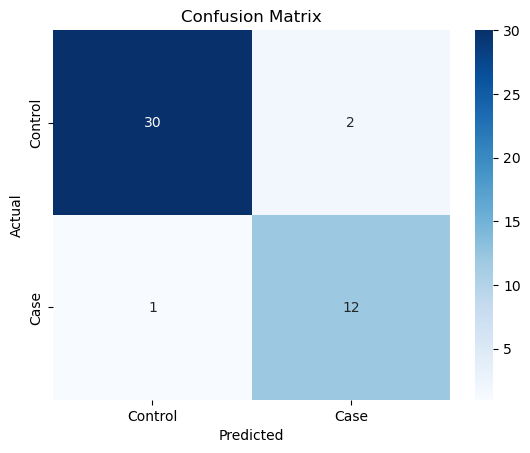

In [144]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [145]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.9333333333333333
F1 Score: 0.8888888888888888
Specificity: 0.9375
Sensitivity: 0.9230769230769231


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - L1 Feature Selection

In [146]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [147]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [148]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [149]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [150]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 0.9377777777777778, F1 Score: 0.9292929292929293, Sensitivity: 0.9583333333333334, Specificity: 0.9224806201550387
Accuracy: 0.7644444444444445, F1 Score: 0.6293706293706294, Sensitivity: 0.46875, Specificity: 0.9844961240310077      
Accuracy: 0.7288888888888889, F1 Score: 0.5343511450381679, Sensitivity: 0.3645833333333333, Specificity: 1.0          
Accuracy: 0.9555555555555556, F1 Score: 0.9479166666666666, Sensitivity: 0.9479166666666666, Specificity: 0.9612403100775194
Accuracy: 0.64, F1 Score: 0.2702702702702703, Sensitivity: 0.15625, Specificity: 1.0                                   
Accuracy: 0.9155555555555556, F1 Score: 0.8961748633879781, Sensitivity: 0.8541666666666666, Specificity: 0.9612403100775194
Accuracy: 0.9377777777777778, F1 Score: 0.9278350515463918, Sensitivity: 0.9375, Specificity: 0.937984496124031        
Accuracy: 0.9377777777777778, F1 Score: 0.93, Sensitivity: 0.96875, Specificity: 0.9147286821705426                    
Accuracy: 0.9333333333333

In [151]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 0.9555555555555556
Best F1 Score: 0.9484536082474226
Best Specificity: 0.9534883720930233
Best Sensitivity: 0.9583333333333334


In [152]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2405 (Dense)                   │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_832 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2406 (Dense)                   │ (None, 80)                  │          10,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_833 (Dropout)                │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2407 (Dense)                   │ (None, 128)                 │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2408 (Dense)                   │ (None, 100)                 │          12,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2409 (Dense)                   │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,617 (182.10 KB)

 Trainable params: 46,617 (182.10 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 128
Neurons in second layer: 80
Dropout rate: 0.6551201949996381
Learning rate: 0.000753710320272019
Number of epochs: 200
Batch size: 48


## Bidirectional LSTM with Bayesian Optimization - L1 Feature Selection

In [154]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [160]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [161]:
space = {
    'units': scope.int(hp.quniform('units', 64, 256, 64)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [162]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [163]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 0.7388888888888889, F1 Score: 0.6499582289055973, Sensitivity: 0.633140756302521, Specificity: 0.8492524916943521
Iteration Results - Accuracy: 0.6388888888888888, F1 Score: 0.543998513563731, Sensitivity: 0.5388655462184874, Specificity: 0.7625622923588039
Iteration Results - Accuracy: 0.6944444444444443, F1 Score: 0.6346320346320345, Sensitivity: 0.6447829131652661, Specificity: 0.7551910299003323
Iteration Results - Accuracy: 0.7555555555555555, F1 Score: 0.7342825361512793, Sensitivity: 0.841999299719888, Specificity: 0.725359911406423
Iteration Results - Accuracy: 0.7333333333333334, F1 Score: 0.6806557639890972, Sensitivity: 0.7057948179271708, Specificity: 0.7798657253599114
Iteration Results - Accuracy: 0.6777777777777777, F1 Score: 0.6371338524286244, Sensitivity: 0.6745448179271708, Specificity: 0.6814091915836102
Iteration Results - Accuracy: 0.5388888888888889, F1 Score: 0.3874840845429081, Sensitivity: 0.48161764705882354, Specificity: 0.67853

In [164]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 192, 'dropout_rate': 0.10789176927584963, 'learning_rate': 0.0005431554477143651, 'epochs': 30, 'batch_size': 64, 'bidirectional': 0}


In [165]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

Test Performance:
Accuracy: 0.7777777777777778
F1 Score: 0.6875
Sensitivity: 0.5789473684210527
Specificity: 0.9230769230769231


## GRU with Bayesian Optimization - L1 Feature Selection

In [17]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [18]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [20]:
space = {
    'units': scope.int(hp.quniform('units', 64, 128, 64)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [23]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [24]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.6333333333333333, F1 Score: 0.6539624183006536, Sensitivity: 0.7574548907882241, Specificity: 0.5292929292929293
Iteration Results - Accuracy: 0.6000000000000001, F1 Score: 0.6280188114659466, Sensitivity: 0.7535612535612536, Specificity: 0.4666666666666666
Iteration Results - Accuracy: 0.5944444444444444, F1 Score: 0.6061506776877904, Sensitivity: 0.687369420702754, Specificity: 0.5202020202020202
Iteration Results - Accuracy: 0.6, F1 Score: 0.6220538720538721, Sensitivity: 0.7301044634377968, Specificity: 0.4875816993464052
Iteration Results - Accuracy: 0.6611111111111111, F1 Score: 0.6537308482273846, Sensitivity: 0.7034188034188035, Specificity: 0.6191919191919192
Iteration Results - Accuracy: 0.6055555555555556, F1 Score: 0.625510058673011, Sensitivity: 0.7407407407407408, Specificity: 0.4875816993464052
Iteration Results - Accuracy: 0.5666666666666668, F1 Score: 0.5544767443732751, Sensitivity: 0.5978157644824311, Specificity: 0.5380867498514558
It

In [25]:
best_params = space_eval(space, best)  
print("Best Parameters:", best_params)  

Best Parameters: {'batch_size': 64, 'dropout_rate': 0.3224123746707528, 'epochs': 30, 'learning_rate': 0.0001354902537099134, 'units': 128}


In [27]:
best_model = create_gru_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [28]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [ ]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")